In [1]:
%matplotlib inline

import gym
import numpy as np
from matplotlib import pyplot as plt

In [2]:
env = gym.envs.make("Skiing-v0")

[2017-01-24 10:19:35,311] Making new env: Skiing-v0


Action space size: 3
['NOOP', 'RIGHT', 'LEFT']
Observation space shape: (250, 160, 3)


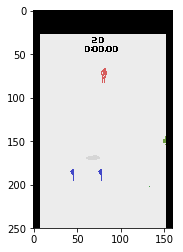

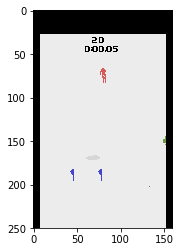

In [3]:
print("Action space size: {}".format(env.action_space.n))
print(env.get_action_meanings())

observation = env.reset()
print("Observation space shape: {}".format(observation.shape))

plt.figure()
plt.imshow(env.render(mode='rgb_array'))

[env.step(2) for x in range(1)]
plt.figure()
plt.imshow(env.render(mode='rgb_array'))

env.render(close=True)

In [4]:
import itertools
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import random
import sys
import tensorflow as tf

rl_path = 'reinforcement-learning/'

if rl_path not in sys.path:
  sys.path.append(rl_path)

from lib import plotting
from collections import deque, namedtuple

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/gpu:0']

In [5]:
# Atari Actions: 0 (noop), 1 (right) and 2 (left) are valid actions
VALID_ACTIONS = [0, 1, 2]

(200, 140, 3)


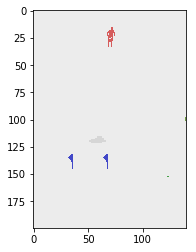

In [6]:
observation_crop = observation[50:,10:-10,:]
print(np.shape(observation_crop))
plt.imshow(observation_crop)

In [7]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[250,160,3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 50, 10, 200, 140)
            self.output = tf.image.resize_images(
                self.output, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [200, 140, 3] Atari RGB State

        Returns:
            A processed [84, 84, 1] state representing grayscale values.
        """
        return sess.run(self.output, { self.input_state: state })

In [8]:
class Estimator():
    """Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)

    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """

        # Placeholders for our input
        # Our input are 3 RGB frames of shape 84, 84 each
        self.X_pl = tf.placeholder(shape=[None, 84, 84, 3], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        X = tf.to_float(self.X_pl) / 255.0
        self.X = X
        batch_size = tf.shape(self.X_pl)[0]

        # Three convolutional layers
        conv1 = tf.contrib.layers.conv2d(
            X, 32, 8, 4, activation_fn=tf.nn.relu)
        conv2 = tf.contrib.layers.conv2d(
            conv1, 64, 4, 2, activation_fn=tf.nn.relu)
        conv3 = tf.contrib.layers.conv2d(
            conv2, 64, 3, 1, activation_fn=tf.nn.relu)

        # Fully connected layers
        flattened = tf.contrib.layers.flatten(conv3)
        fc1 = tf.contrib.layers.fully_connected(flattened, 512)
        self.predictions = tf.contrib.layers.fully_connected(fc1, 3)

        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calcualte the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())

        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])


    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 84, 84, 3]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 84, 84, 3]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

In [21]:
# For Testing....

tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

e = Estimator(scope="test")
sp = StateProcessor()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Example observation batch
    observation = env.reset()
    
    print(np.shape(observation))
    
    observation_p = sp.process(sess, observation)
    observation = np.stack([observation_p] * 3, axis=2)
    observations = np.array([observation] * 2)
    
    # Test Prediction
    print(e.predict(sess, observations))

    # Test training step
    y = np.array([10.0, 10.0])
    a = np.array([1, 3])
    print(e.update(sess, observations, a, y))

/home/nmurzin/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


(250, 160, 3)
[[ 0.07146844  0.          0.        ]
 [ 0.07146844  0.          0.        ]]
100.0


In [9]:
def copy_model_parameters(sess, estimator1, estimator2):
    """
    Copies the model parameters of one estimator to another.

    Args:
      sess: Tensorflow session instance
      estimator1: Estimator to copy the paramters from
      estimator2: Estimator to copy the parameters to
    """
    e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
    e1_params = sorted(e1_params, key=lambda v: v.name)
    e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
    e2_params = sorted(e2_params, key=lambda v: v.name)

    update_ops = []
    for e1_v, e2_v in zip(e1_params, e2_params):
        op = e2_v.assign(e1_v)
        update_ops.append(op)

    sess.run(update_ops)

In [10]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [11]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    state_processor,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size=500000,
                    replay_memory_init_size=50000,
                    update_target_estimator_every=10000,
                    discount_factor=0.99,
                    epsilon_start=1.0,
                    epsilon_end=0.1,
                    epsilon_decay_steps=500000,
                    batch_size=32,
                    record_video_every=50):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.

    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: Estimator object used for the targets
        state_processor: A StateProcessor object
        num_episodes: Number of episodes to run for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sampel when initializing 
          the reply memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every N steps
        discount_factor: Lambda time discount factor
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory
        record_video_every: Record a video every N episodes

    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # The replay memory
    replay_memory = []

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    monitor_path = os.path.join(experiment_dir, "monitor")

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    # Get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(
        q_estimator,
        len(VALID_ACTIONS))

    # Populate the replay memory with initial experience
    print("Populating replay memory...")
    state = env.reset()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 3, axis=2)
    for i in range(replay_memory_init_size):
        action_probs = policy(sess, state, epsilons[total_t])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
        next_state = state_processor.process(sess, next_state)
        next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        replay_memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            state = state_processor.process(sess, state)
            state = np.stack([state] * 3, axis=2)
        else:
            state = next_state

    # Record videos
    import gym.wrappers
    env = gym.wrappers.monitoring.Monitor(env, monitor_path,
                      resume=True,
                      video_callable=lambda count: count % record_video_every == 0)

    for i_episode in range(num_episodes):

        # Save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)

        # Reset the environment
        state = env.reset()
        state = state_processor.process(sess, state)
        state = np.stack([state] * 3, axis=2)
        loss = None

        # One step in the environment
        for t in itertools.count():

            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]

            # Add epsilon to Tensorboard
            episode_summary = tf.Summary()
            episode_summary.value.add(simple_value=epsilon, tag="epsilon")
            q_estimator.summary_writer.add_summary(episode_summary, total_t)

            # Maybe update the target estimator
            if total_t % update_target_estimator_every == 0:
                copy_model_parameters(sess, q_estimator, target_estimator)
                print("\nCopied model parameters to target network.")

            # Print out which step we're on, useful for debugging.
            print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    t, total_t, i_episode + 1, num_episodes, loss), end="")
            sys.stdout.flush()

            # Take a step
            action_probs = policy(sess, state, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
            next_state = state_processor.process(sess, next_state)
            next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)

            # If our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)

            # Save transition to replay memory
            replay_memory.append(Transition(state, action, reward, next_state, done))   

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))

            # Calculate q values and targets
            # This is where Double Q-Learning comes in!
            q_values_next = q_estimator.predict(sess, next_states_batch)
            best_actions = np.argmax(q_values_next, axis=1)
            q_values_next_target = target_estimator.predict(sess, next_states_batch)
            targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * \
                discount_factor * q_values_next_target[np.arange(batch_size), best_actions]

            # Perform gradient descent update
            states_batch = np.array(states_batch)
            loss = q_estimator.update(sess, states_batch, action_batch, targets_batch)

            if done:
                break

            state = next_state
            total_t += 1

        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=stats.episode_rewards[i_episode], node_name="episode_reward", tag="episode_reward")
        episode_summary.value.add(simple_value=stats.episode_lengths[i_episode], node_name="episode_length", tag="episode_length")
        q_estimator.summary_writer.add_summary(episode_summary, total_t)
        q_estimator.summary_writer.flush()

        yield total_t, plotting.EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])

    env.monitor.close()
    return stats

In [ ]:
tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments/{}".format(env.spec.id))

# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q", summaries_dir=experiment_dir)
target_estimator = Estimator(scope="target_q")

# State processor
state_processor = StateProcessor()

# Run it!
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t, stats in deep_q_learning(sess,
                                    env,
                                    q_estimator=q_estimator,
                                    target_estimator=target_estimator,
                                    state_processor=state_processor,
                                    experiment_dir=experiment_dir,
                                    num_episodes=10000,
                                    replay_memory_size=500000,
                                    replay_memory_init_size=50000,
                                    update_target_estimator_every=10000,
                                    epsilon_start=0.9,
                                    epsilon_end=0.1,
                                    epsilon_decay_steps=5000000,
                                    discount_factor=0.99,
                                    batch_size=32):

        print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))

/home/nmurzin/.conda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loading model checkpoint /home/nmurzin/experiments/Skiing-v0/checkpoints/model...

Populating replay memory...
